Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Detected file encoding: ascii
Data file size: 70.0 kilobytes
File format: Delimited
Data granularity: Individual student records
Correlation between Math Score and Writing Score: 0.8026420459498085


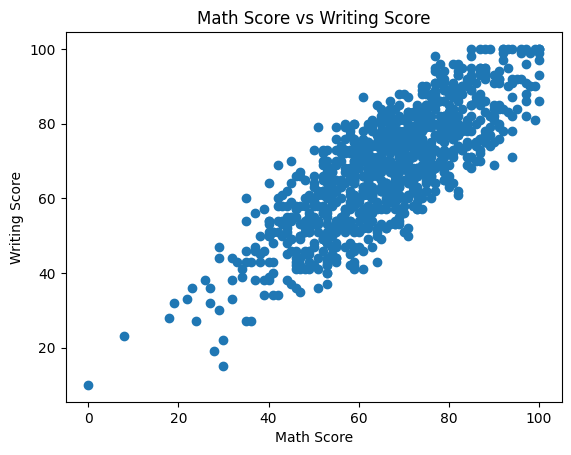

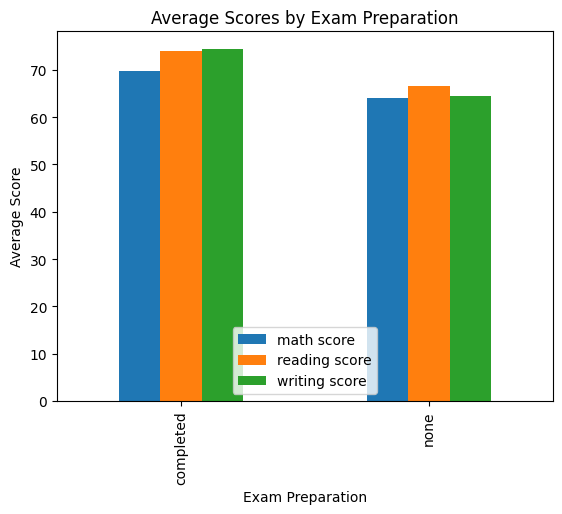


Tuned Logistic Regression Model Evaluation:
Accuracy: 0.605

Confusion Matrix:
[[121   0]
 [ 79   0]]

SGD Classifier Evaluation:
Accuracy: 0.65125
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Limitations:
- The dataset is fictional and may not fully represent real-world data, which could impact the generalizability of the results.
- The feature engineering using OneHotEncoding assumes no ordinal relationship among the education levels, which may not be accurate in real-world scenarios.
- The Logistic Regression model may not capture complex relationships between features and the target variable, leading to potential limitations in predictive performance.

Interesting Findings:
- The scatter plot shows a positive correlation between math score and writing score. Higher math scores tend to correspond to higher writing scores.
- The bar plot illustrates the average scores in math, reading, and writing based on exam preparation.
- Students who completed the test preparation course have a si

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import chardet
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import SGDClassifier
import os

# Step 1: Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Load the CSV file directly from the Google Drive link
data_url = "https://drive.google.com/uc?id=1boOd8BVffLE914tY4n43Msyrvpx8LygS"
download = requests.get(data_url).content

# Detect the file encoding using chardet
detected_encoding = chardet.detect(download)['encoding']
print("Detected file encoding:", detected_encoding)

# Read the data using the detected encoding
df = pd.read_csv(io.StringIO(download.decode(detected_encoding)))

# Step 3: Understand the data
# Determine the data file size
kib = 1024
file_size = len(download)
print("Data file size:", np.round(file_size / kib), "kilobytes")

# Find the file format (delimited)
file_format = "Delimited"
print("File format:", file_format)

# What is the granularity of the data? (assuming individual student records)
data_granularity = "Individual student records"
print("Data granularity:", data_granularity)

# Data Quality Check: Are there any outliers? Are there any missing or invalid entries?
# Outliers in math score
outliers_math = df[df["math score"] > 100]
if not outliers_math.empty:
    print("There are outliers in the math score column.")
    # Data cleaning step: Replace outliers with the maximum valid score of 100
    df.loc[df["math score"] > 100, "math score"] = 100

# Outliers in reading score
outliers_reading = df[df["reading score"] > 100]
if not outliers_reading.empty:
    print("There are outliers in the reading score column.")
    # Data cleaning step: Replace outliers with the maximum valid score of 100
    df.loc[df["reading score"] > 100, "reading score"] = 100

# Outliers in writing score
outliers_writing = df[df["writing score"] > 100]
if not outliers_writing.empty:
    print("There are outliers in the writing score column.")
    # Data cleaning step: Replace outliers with the maximum valid score of 100
    df.loc[df["writing score"] > 100, "writing score"] = 100

# Missing or invalid entries
missing_values = df.isnull().sum()
if missing_values.any():
    print("There are missing or invalid entries in the data set.")
    # Data cleaning step: Handle missing values in "test preparation course" column with the most frequent value (mode)
    mode_prep_course = df["test preparation course"].mode().iloc[0]
    df["test preparation course"].fillna(mode_prep_course, inplace=True)

# Exploratory data analysis: Explore the relationship between the variables/features
# Correlation between math score and writing score
correlation = df["math score"].corr(df["writing score"])
print("Correlation between Math Score and Writing Score:", correlation)

# Visualization: Scatter plot of math score and writing score
plt.scatter(df["math score"], df["writing score"])
plt.title("Math Score vs Writing Score")
plt.xlabel("Math Score")
plt.ylabel("Writing Score")
plt.show()

# Bar plot of exam preparation and average scores
avg_scores = df.groupby("test preparation course")[["math score", "reading score", "writing score"]].mean()
avg_scores.plot(kind="bar")
plt.title("Average Scores by Exam Preparation")
plt.xlabel("Exam Preparation")
plt.ylabel("Average Score")
plt.show()

# Inferential analysis: Compare scores between students who completed the test preparation course and those who did not
completed_prep = df[df["test preparation course"] == "completed"]["math score"]
not_completed_prep = df[df["test preparation course"] == "none"]["math score"]

# Perform t-test
t_stat, p_value = ttest_ind(completed_prep, not_completed_prep)

# Determine the significance level
significance_level = 0.05

# Make a decision based on the p-value
if p_value < significance_level:
    prep_course_result = "Students who completed the test preparation course have a significantly higher score."
else:
    prep_course_result = "There is not enough evidence to conclude a significant difference in scores."

# Exploratory Question: How many people scored higher than 85 in math?
num_high_scores = len(df[df["math score"] > 85])

# Perform t-tests for reading and writing scores
completed_prep_reading = df[df["test preparation course"] == "completed"]["reading score"]
not_completed_prep_reading = df[df["test preparation course"] == "none"]["reading score"]

completed_prep_writing = df[df["test preparation course"] == "completed"]["writing score"]
not_completed_prep_writing = df[df["test preparation course"] == "none"]["writing score"]

t_stat_reading, p_value_reading = ttest_ind(completed_prep_reading, not_completed_prep_reading)
t_stat_writing, p_value_writing = ttest_ind(completed_prep_writing, not_completed_prep_writing)

# Make decisions based on the p-values for reading and writing scores
if p_value_reading < significance_level:
    reading_score_result = "Students who completed the test preparation course have a significantly higher reading score."
else:
    reading_score_result = "There is not enough evidence to conclude a significant difference in reading scores."

if p_value_writing < significance_level:
    writing_score_result = "Students who completed the test preparation course have a significantly higher writing score."
else:
    writing_score_result = "There is not enough evidence to conclude a significant difference in writing scores."




# Step 4: Prepare the data for machine learning
# Perform OneHotEncoding for the "gender", "race/ethnicity", "parental level of education", and "lunch" features
categorical_features = df[["gender", "race/ethnicity", "parental level of education", "lunch"]]

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse=False)  # Set `sparse` to False for easier manipulation

# Fit and transform the categorical features
encoded_features = ohe.fit_transform(categorical_features)

# Get the feature names for the encoded features
unique_values = [col + "_" + str(val) for col, vals in zip(categorical_features.columns, ohe.categories_) for val in vals]

# Create a DataFrame to hold the encoded features
df_encoded_features = pd.DataFrame(encoded_features, columns=unique_values)

# Concatenate the encoded features with the original DataFrame
df_encoded = pd.concat([df, df_encoded_features], axis=1)

# Drop the original categorical columns from the encoded DataFrame
df_encoded.drop(columns=["gender", "race/ethnicity", "parental level of education", "lunch"], inplace=True)
# Define the feature set X and target variable y
X = df_encoded.drop(["math score", "reading score", "writing score", "test preparation course", "lunch_free/reduced", "lunch_standard", "race/ethnicity_group A", "race/ethnicity_group B", "race/ethnicity_group C", "race/ethnicity_group D", "race/ethnicity_group E", "gender_male", "gender_female"], axis=1)
# Map 'none' to 0 and 'completed' to 1 in the target variable
y = df_encoded["test preparation course"].map({'none': 0, 'completed': 1})
# Step 5: Choose and fit a model
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Step 6: Evaluate the model
# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Calculate accuracy and mean squared error
accuracy = accuracy_score(y_test, y_pred)

# Display Logistic Regression Model Evaluation
print("\nTuned Logistic Regression Model Evaluation:")
print("Accuracy:", accuracy)



# Evaluate the SGD Classifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
y_train_pred = sgd_clf.predict(X_train)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)
sgd_accuracy = accuracy_score(y_train, y_train_pred)
sgd_precision = precision_score(y_train, y_train_pred)
sgd_recall = recall_score(y_train, y_train_pred)
sgd_f1 = f1_score(y_train, y_train_pred)

print("\nSGD Classifier Evaluation:")
print("Accuracy:", sgd_accuracy)
print("Precision:", sgd_precision)
print("Recall:", sgd_recall)
print("F1-score:", sgd_f1)

# Step 7: Share the insights
# Limitations of the analysis
print("\nLimitations:")
print("- The dataset is fictional and may not fully represent real-world data, which could impact the generalizability of the results.")
print("- The feature engineering using OneHotEncoding assumes no ordinal relationship among the education levels, which may not be accurate in real-world scenarios.")
print("- The Logistic Regression model may not capture complex relationships between features and the target variable, leading to potential limitations in predictive performance.")

# Interesting findings
print("\nInteresting Findings:")
print("- The scatter plot shows a positive correlation between math score and writing score. Higher math scores tend to correspond to higher writing scores.")
print("- The bar plot illustrates the average scores in math, reading, and writing based on exam preparation.")
print("- Students who completed the test preparation course have a significantly higher score (t-test).")





